# Signatures that are allowed

In [4]:
from inspect import signature
def foo(a, /,b, *args, c,  d=10,**kwargs):
    pass

sig = signature(foo)
for param in sig.parameters.values():
    print(param.kind)
    #if (param.kind == param.KEYWORD_ONLY and
    #                   param.default is param.empty):
    #    print('Parameter:', param)

POSITIONAL_ONLY
POSITIONAL_OR_KEYWORD
VAR_POSITIONAL
KEYWORD_ONLY
KEYWORD_ONLY
VAR_KEYWORD


# From signature_dict to possible ranges

In [5]:
# (a,b,/,c,d,e,*,f,g,**kwargs)



In [28]:

from dataclasses import dataclass
from typing import Optional
from enum import Enum
from collections import Counter
from i2 import Sig
from i2.signatures import PK , VP, VK, PO, KO


def transform_key(d, func):
    return {func(k):v for k,v in d.items()}

kind_to_symbol = {PO: 'PO',
         PK: 'PK',
         VP:'VP',
         KO:'KO',
        VK: 'VK'}

def param_kind_counter(func):
    sig = Sig(func)
    param_list = [param.kind for param in Sig(foo).parameters.values()]
    cc = Counter(param_list)
    res = transform_key(dict(cc), kind_to_symbol_func)
    return res

def kind_to_symbol_func(k):
    return kind_to_symbol[k]


@dataclass
class DefinitionSig:
    PO:Optional[int]=0
    PK:Optional[int]=0
    VP:Optional[int]=0
    KO:Optional[int]=0
    VK:Optional[int]=0
        

@dataclass
class CallSig:
    pos:int=0
    k:int=0
    
def point_is_in_region(point, segment, region_type):
    x,y = point
    po, pk, ko = segment

    if region_type==0:
        return po<=x<=po+pk and x+y==sum(list(segment))
        
    if region_type==1:
        return ko+pk>=y>=ko and  x+y>=sum(list(segment)) 
    if region_type==2:
        return po<=x<=po+pk and x+y>=sum(list(segment))
    if region_type==3:
        return x>=po and y>=ko and x+y>=sum(list(segment))

def segment_is_in_region(segment_1, segment_2, region_type):
    po_1, pk_1, ko_1 = segment_1
    point_a = (po_1, pk_1+ko_1)
    point_b= (po_1+pk_1, ko_1)
    
    cond_a = point_is_in_region(point_a, segment_2, region_type)
    cond_b = point_is_in_region(point_b, segment_2, region_type)
    
    return cond_a and cond_b
    
def segment_from_definition_sig(d: DefinitionSig):
    segment = (d.PO, d.PK, d.KO)
    return segment

def region_type(d: DefinitionSig):
    vp, vk = d.VP, d.VK
    return 2*vk+vp


def is_compatible_with(d: DefinitionSig, e:DefinitionSig):
    region_type_d = region_type(d)
    region_type_e = region_type(e)
    if (region_type_d, region_type_e) in [(1,2), (2,1), (1,0), (2,0),(3,0),(3,1),(3,2)]:
        return False
    
    segment_d = segment_from_definition_sig(d)
    segment_e = segment_from_definition_sig(e)
    return segment_is_in_region(segment_d, segment_e, region_type_e)

def call_is_compatible(d:DefinitionSig, c=CallSig):
    point_c = (c.pos, c.k)
    region_type_d = region_type(d)
    segment_d = segment_from_definition_sig(d)
    
    cond = point_is_in_region(point_c, segment_d, region_type_d)
    
    return cond

In [29]:
param_kind_counter(foo)

{'PO': 1, 'PK': 1, 'VP': 1, 'KO': 2, 'VK': 1}

In [30]:
# {'PO': 1, 'PK': 1, 'VP': 1, 'KO': 2, 'VK': 1}
d= DefinitionSig(PO= 1, PK= 1, VP= 0, KO= 2, VK=1)


In [31]:
c = CallSig(pos=1, k=2) # foo(a, b=2, c=3)

In [32]:
# 

# Types of regions

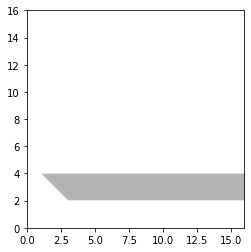

In [33]:
import numpy as np
import matplotlib.pyplot as plt


d = np.linspace(0,16,300)
x,y = np.meshgrid(d,d)
plt.imshow( ((y>=2) & (y<=4)&(5-x<=y)).astype(int) , 
                extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3);
 

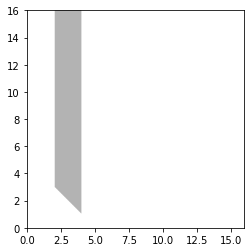

In [34]:
# type 2
d = np.linspace(0,16,300)
x,y = np.meshgrid(d,d)
plt.imshow( ((x>=2) & (x<=4)&(5-x<=y)).astype(int) , 
                extent=(0.,x.max(),0.,y.max()),origin="lower", cmap="Greys", alpha = 0.3);
 

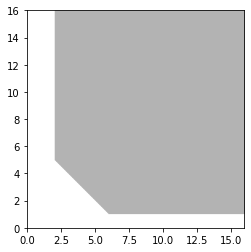

In [35]:
# type 3
d = np.linspace(0,16,300)
x,y = np.meshgrid(d,d)
plt.imshow( ((x>=2) & (y>=1)&(7-x<=y)).astype(int) , 
                extent=(0.,x.max(),0.,y.max()),origin="lower", cmap="Greys", alpha = 0.3);
 

# Regions inclusions

* Every function with a given signature (po,pk,vp,ko,vk) can be called in many different ways, using (p,k) (ie p positional and k keywords) arguments. 
* The possible allowed choices define a region in the plane (p,k).
* Signature1 is compatible with Signature2 if every allowed way of calling func1 is an allowed way of calling func2: in other words region1 is included in region2
* checking the inclusions of infinite regions would involve an infinite number of checks. However, the regions are convex and of a special shape: it is enough to check the inclusions of two corner points. In essence, we use the fact that regions are "invariant under positive translations" to the right or to the top.

In [37]:
d= DefinitionSig(PO= 1, PK= 1, VP= 0, KO= 2, VK=1)

e= DefinitionSig(PO= 1, PK= 1, VP= 0, KO= 2, VK=1)

cc = CallSig(pos=2, k=1)

In [23]:
call_is_compatible(d,cc)

False

In [24]:
segment_from_definition_sig(d)
region_type(d)

2

In [25]:
is_compatible_with(d,e)

True

# More elegant reformulations

## Complete set of inequalitites in the plane

### (0,0) comparison

$$ko_2 >= ko_1$$ and $$(ko_2+pk_2)<=(ko_1+pk_1)$$ and $$ko_2+pk_2+po_2 = ko_1+pk_1+po_1$$

### (0,1) and (1,1) comparison

$$ko_2 >= ko_1$$ and $$(ko_2+pk_2)<=(ko_1+pk_1)$$ and $$ko_2+pk_2+po_2 >= ko_1+pk_1+po_1$$

### (0,2), (1,2), (2,2) comparison

$$ko_2 >= ko_1$$ and $$po_2>=po_1$$ and $$ko_2+pk_2+po_2 >= ko_1+pk_1+po_1$$


**Remark**: by doing linear invertible change of variables we can reduce to conditions like
$$x_2 >= x_1$$ and $$y_2>=y_1$$ and $$z_2 >= z_1$$

# Scrap

In [1]:
'keu'.upper()

'KEU'

In [3]:
def f(a,b,c,d):
    pass

f(1,2,c=3,d=5)